In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from typing import Optional, Tuple, List

import warnings
warnings.filterwarnings('ignore')

In [2]:
class MultiLoglossForLGBM:
    """Custom multi-class logloss for LightGBM with flexible ground truth probabilities"""
    def __init__(self, n_class: int=3, grand_truth: np.ndarray = np.empty(0), epsilon: float=1e-32, use_softmax=True):
        self.name = "SFC_loss"
        self.n_class = n_class
        self.grand_truth = grand_truth
        self.epsilon = epsilon
        self.prob_func = self._get_prob_value if use_softmax else lambda x: x

    def __call__(self, preds: np.ndarray, labels: np.ndarray, weight: Optional[np.ndarray] = None) -> float:
        prob = self.prob_func(preds)  # Convert logits to probabilities
        labels_1hot = self._get_1hot_label(labels)
        loss_per_sample = np.sum(-np.log(prob) * labels_1hot, axis=1)
        return np.average(loss_per_sample, weights=weight)

    def _calc_grad_and_hess(self, preds: np.ndarray, labels: np.ndarray, weight: Optional[np.ndarray] = None) -> Tuple[np.ndarray, np.ndarray]:
        prob = self.prob_func(preds)
        labels_1hot = self._get_1hot_label(labels)
        grad = prob - labels_1hot
        hess = prob * (1 - prob)
        if weight is not None:
            grad = grad * weight[:, None]
            hess = hess * weight[:, None]
        return grad, hess

    def return_loss(self, preds: np.ndarray, data: lgb.Dataset) -> Tuple[str, float, bool]:
        labels = data.get_label()
        weight = data.get_weight()
        n_example = len(labels)
        preds = preds.reshape(self.n_class, n_example).T
        loss = self(preds, labels, weight)
        return self.name, loss, False

    def return_grad_and_hess(self, preds: np.ndarray, data: lgb.Dataset) -> Tuple[np.ndarray, np.ndarray]:
        labels = data.get_label()
        weight = data.get_weight()
        n_example = len(labels)
        preds = preds.reshape(self.n_class, n_example).T
        grad, hess = self._calc_grad_and_hess(preds, labels, weight)
        grad = grad.T.reshape(n_example * self.n_class)
        hess = hess.T.reshape(n_example * self.n_class)
        return grad, hess

    def _get_prob_value(self, preds: np.ndarray) -> np.ndarray:
        upper = np.exp(preds)
        prob = upper / np.sum(upper, axis=1, keepdims=True)
        prob = np.clip(prob, self.epsilon, 1 - self.epsilon)
        return prob

    def _get_1hot_label(self, labels: np.ndarray) -> np.ndarray:
        n_example = len(labels)
        onehot = np.zeros((n_example, self.n_class))
        if self.grand_truth.shape[0] == 0:
            for i, label in enumerate(labels):
                onehot[i, int(label)] = 1
        else:
            for i, label in enumerate(labels):
                onehot[i, :] = self.grand_truth[int(label)]
        return onehot

In [3]:
def generate_data(num_rows=1000, num_genes=1998, n_class=3, data_overlap=None, seed=42) -> Tuple[np.ndarray, np.ndarray]:
    """Generate synthetic gene expression data with overlap. (for demonstaration)"""
    np.random.seed(seed)
    if data_overlap is None:
        data_overlap = [-0.3, 0.01, 0.025, 0.05, 0.10, 0.15, 0.2, 0.3]
    generated_data = np.zeros((num_rows, num_genes, len(data_overlap)))

    for k, overlap in enumerate(data_overlap):
        base_dist_range = 1. / (n_class - (n_class - 1) * overlap)
        base_dist_range2 = 1. / (2 - overlap)
        for pt_number in range(num_rows):
            pt_class = pt_number % n_class
            # gene1 value range depending on class and overlap
            min_gene1 = base_dist_range * pt_class * (1 - overlap)
            max_gene1 = base_dist_range * (pt_class * (1 - overlap) + 1.)
            gene1_value = np.random.uniform(min_gene1, max_gene1)
            pt_class2 = pt_class % 2
            # gene2 value range depending on class and overlap
            min_gene2 = base_dist_range2 * pt_class2 * (1 - overlap)
            max_gene2 = base_dist_range2 * (pt_class2 * (1 - overlap) + 1.)
            gene2_value = np.random.uniform(min_gene2, max_gene2)
            other_genes = np.random.uniform(0, 1, size=num_genes - 2)
            generated_data[pt_number, :, k] = np.concatenate(([gene1_value, gene2_value], other_genes))
    pt_class = np.arange(num_rows) % n_class
    return generated_data, pt_class, data_overlap

In [4]:
def plot_generated_data(generated_data: np.ndarray, pt_class: np.ndarray, data_overlap: List[float]):
    """Plot gene1 vs gene2 scatter for each overlap. (fro demonstration)"""
    sns.set_palette('bright')
    n = len(data_overlap)
    plt.figure(figsize=(12, 3))
    for k in range(n):
        plt.subplot(1, n, k + 1)
        for class_id in range(3):
            idx = np.where(pt_class == class_id)[0]
            plt.scatter(generated_data[idx, 0, k], generated_data[idx, 1, k], s=1, alpha=0.5)
        plt.title(f"overlap={data_overlap[k]}")
        plt.xlabel('feature 1')
        if k == 0:
            plt.ylabel('feature 2')
        else:
            plt.tick_params(labelleft=False)
    plt.tight_layout()
    plt.show()

In [5]:
def run_cv_lgbm(
    X: np.ndarray,
    y: np.ndarray,
    grand_truth_SFC: np.ndarray,
    params: dict,
    n_splits: int = 5,
    repeated: int = 1,
    acc_threshold: float = 2 / 3,
    random_state: int = 2022
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Run cross-validation for GC and SFC models with LightGBM.
    Optionally repeat stratified k-fold multiple times.
    Returns mean/std of feature importance difference for folds exceeding accuracy threshold.
    """

    n_class = params['num_class']
    feature_names = [f"feature {i+1}" for i in range(X.shape[1])] # 

    # Prepare containers to accumulate importances and accuracies
    df_importance_GC_mean = pd.DataFrame(columns=[], index=feature_names)
    df_importance_GC_std = pd.DataFrame(columns=[], index=feature_names)
    df_importance_SFC_mean = pd.DataFrame(columns=[], index=feature_names)
    df_importance_SFC_std = pd.DataFrame(columns=[], index=feature_names)
    df_importance_Diff_mean = pd.DataFrame(columns=[], index=feature_names)
    df_importance_Diff_std = pd.DataFrame(columns=[], index=feature_names)

    all_overlaps = []

    for repeat_i in range(repeated):
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state + repeat_i)
        cv_splits = list(skf.split(X, y))

        for fold_i, (train_idx, valid_idx) in enumerate(cv_splits):
            print(f"Repeat {repeat_i + 1}/{repeated} Fold {fold_i + 1}/{n_splits}")
            fold_name = f"repeat{repeat_i}_fold{fold_i}"

            X_train, y_train = X[train_idx], y[train_idx]
            X_valid, y_valid = X[valid_idx], y[valid_idx]

            lgb_train = lgb.Dataset(X_train, label=y_train)
            lgb_valid = lgb.Dataset(X_valid, label=y_valid, reference=lgb_train)

            # Train GC model (standard multiclass logloss)
            model_GC = lgb.train(
                params,
                train_set=lgb_train,
                valid_sets=[lgb_train, lgb_valid],
                valid_names=['train', 'valid'],
                early_stopping_rounds=70,
                verbose_eval=False
            )

            y_pred_GC_prob = model_GC.predict(X_valid, num_iteration=model_GC.best_iteration)
            y_pred_GC = np.argmax(y_pred_GC_prob, axis=1)
            acc_GC = accuracy_score(y_valid, y_pred_GC)

            # Train SFC model (custom loss)
            sfc_loss = MultiLoglossForLGBM(n_class=n_class, grand_truth=grand_truth_SFC)
            model_SFC = lgb.train(
                params,
                train_set=lgb_train,
                valid_sets=[lgb_train, lgb_valid],
                valid_names=['train', 'valid'],
                fobj=sfc_loss.return_grad_and_hess,
                feval=lambda preds, data: sfc_loss.return_loss(preds, data),
                early_stopping_rounds=70,
                verbose_eval=False
            )

            y_pred_SFC_prob = model_SFC.predict(X_valid, num_iteration=model_SFC.best_iteration)
            y_pred_SFC = np.argmax(y_pred_SFC_prob, axis=1)
            acc_SFC = accuracy_score(y_valid, y_pred_SFC)

            print(f"GC accuracy: {acc_GC:.3f}, SFC accuracy: {acc_SFC:.3f}")

            # Feature importances normalized
            imp_GC = model_GC.feature_importance(importance_type='gain')
            imp_GC /= np.sum(imp_GC)
            imp_SFC = model_SFC.feature_importance(importance_type='gain')
            imp_SFC /= np.sum(imp_SFC)

            # Store results per fold
            if fold_i == 0 and repeat_i == 0:
                # Initialize containers on first run
                df_importance_GC = pd.DataFrame(columns=[fold_name], index=feature_names)
                df_importance_SFC = pd.DataFrame(columns=[fold_name], index=feature_names)
                df_importance_Diff = pd.DataFrame(columns=[fold_name], index=feature_names)
                df_importance_GC[fold_name] = imp_GC
                df_importance_SFC[fold_name] = imp_SFC
                df_importance_Diff[fold_name] = imp_SFC - imp_GC                
                df_acc = pd.DataFrame(columns=[fold_name], index=['GC', 'SFC'])
            else:
                # Append new columns
                df_importance_GC[fold_name] = imp_GC
                df_importance_SFC[fold_name] = imp_SFC
                df_importance_Diff[fold_name] = imp_SFC - imp_GC
                df_acc[fold_name] = [acc_GC, acc_SFC]

        # After all folds in this repeat, accumulate means/stds for this repeat (optional)

    # Filter folds where accuracy > threshold in both GC and SFC models
    valid_folds = df_acc.columns[(df_acc.loc['GC'] >= acc_threshold) & (df_acc.loc['SFC'] >= acc_threshold)]

    df_importance_GC_mean = df_importance_GC[valid_folds].mean(axis=1)
    df_importance_GC_std = df_importance_GC[valid_folds].std(axis=1)
    df_importance_SFC_mean = df_importance_SFC[valid_folds].mean(axis=1)
    df_importance_SFC_std = df_importance_SFC[valid_folds].std(axis=1)
    df_importance_Diff_mean = df_importance_Diff[valid_folds].mean(axis=1)
    df_importance_Diff_std = df_importance_Diff[valid_folds].std(axis=1)
    
    # --- compute gene ranking from df_importance_Diff ---
    # Ranking importance difference
    gene_rank_matrix = pd.DataFrame(index=feature_names)

    for i, col in enumerate(df_importance_Diff.columns):
        col_name = f"fold_{i}"
        gene_rank_matrix[col_name] = df_importance_Diff[col].rank(ascending=False, method="min")
        
    # Sum ranks across all folds (NaNs handled)
    gene_rank_matrix["rank_sum"] = gene_rank_matrix.sum(axis=1, skipna=True)
    
    # Wrap results into DataFrames for return
    results = {
        "importance_GC_mean": df_importance_GC_mean,
        "importance_GC_std": df_importance_GC_std,
        "importance_SFC_mean": df_importance_SFC_mean,
        "importance_SFC_std": df_importance_SFC_std,
        "importance_Diff_mean": df_importance_Diff_mean,
        "importance_Diff_std": df_importance_Diff_std,
        "gene_rank_matrix": gene_rank_matrix
    }

    return results


In [6]:
def plot_feature_importance_comparison(results: dict, feature_names: List[str]):
    """Plot feature importance means and differences with error bars for selected features. First 2 features willbe compared."""
    sns.set_style('white')
    sns.set_palette(['#000000', '#ABABAB'])

    # Features of interest
    genes = feature_names[:2]
    df_imp_GC_mean = results['importance_GC_mean']
    df_imp_GC_std = results['importance_GC_std']
    df_imp_SFC_mean = results['importance_SFC_mean']
    df_imp_SFC_std = results['importance_SFC_std']
    df_imp_Diff_mean = results['importance_Diff_mean']
    df_imp_Diff_std = results['importance_Diff_std']

    x = np.arange(len(genes))
    width = 0.3

    fig, ax = plt.subplots(1, 3, figsize=(12, 3))

    # GC importance
    ax[0].bar(x, [df_imp_GC_mean[gene] for gene in genes], yerr=[df_imp_GC_std[gene] for gene in genes], width=width, capsize=5)
    ax[0].set_title("GC importance")
    ax[0].set_xticks(x)
    ax[0].set_xticklabels(genes)
    ax[0].set_ylim(0, max(df_imp_GC_mean[genes].max(), 0.2) * 1.2)

    # SFC importance
    ax[1].bar(x, [df_imp_SFC_mean[gene] for gene in genes], yerr=[df_imp_SFC_std[gene] for gene in genes], width=width, capsize=5)
    ax[1].set_title("SFC importance")
    ax[1].set_xticks(x)
    ax[1].set_xticklabels(genes)
    ax[1].set_ylim(0, max(df_imp_SFC_mean[genes].max(), 0.2) * 1.2)

    # Difference
    ax[2].bar(x, [df_imp_Diff_mean[gene] for gene in genes], yerr=[df_imp_Diff_std[gene] for gene in genes], width=width, capsize=5)
    ax[2].set_title("Difference (SFC - GC)")
    ax[2].set_xticks(x)
    ax[2].set_xticklabels(genes)
    ax[2].axhline(0, color='gray', linestyle='dashed')
    ax[2].set_ylim(min(df_imp_Diff_mean[genes].min(), -0.1) * 1.2, max(df_imp_Diff_mean[genes].max(), 0.1) * 1.2)

    plt.tight_layout()
    plt.show()

In [7]:
def plot_feature_importance_comparison_topN(
    importance_gc_mean: pd.DataFrame,
    importance_gc_std: pd.DataFrame,
    importance_sfc_mean: pd.DataFrame,
    importance_sfc_std: pd.DataFrame,
    importance_diff_mean: pd.DataFrame,
    importance_diff_std: pd.DataFrame,
    gene_rank_matrix: pd.DataFrame,
    top_n: int = 10
):
    """
    Plot comparison of GC vs SFC feature importance for top-N genes based on rank sum.
    Args:
        importance_gc_mean: DataFrame of GC feature importance means
        importance_gc_std: DataFrame of GC feature importance stds
        importance_sfc_mean: DataFrame of SFC feature importance means
        importance_sfc_std: DataFrame of SFC feature importance stds
        importance_diff_mean: DataFrame of Diff (SFC - GC) importance means
        importance_diff_std: DataFrame of Diff importance stds
        gene_rank_matrix: DataFrame containing fold-wise ranks and rank sum
        top_n: Number of top genes to include
    """
    # Get top-N genes with smallest rank sum
    top_genes = gene_rank_matrix.sort_values(by="rank_sum", ascending=True).head(top_n).index.tolist()

    def compute_mean_and_std(df_mean, df_std, genes):
        if isinstance(df_mean, pd.Series):
            # If Series, no need to average across axis
            mean_vals = df_mean.loc[genes]
            std_vals = df_std.loc[genes]
        else:
            # DataFrame: average across columns (folds)
            mean_vals = df_mean.loc[genes].mean(axis=1)
            std_vals = df_std.loc[genes].mean(axis=1)
        return mean_vals, std_vals

    # Get values for GC and SFC
    gc_mean, gc_std = compute_mean_and_std(importance_gc_mean, importance_gc_std, top_genes)
    sfc_mean, sfc_std = compute_mean_and_std(importance_sfc_mean, importance_sfc_std, top_genes)
    diff_mean, diff_std = compute_mean_and_std(importance_diff_mean, importance_diff_std, top_genes)

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    # GC vs SFC bar plot
    df_plot_mean = pd.DataFrame({'GC': gc_mean, 'SFC': sfc_mean})
    df_plot_std = pd.DataFrame({'GC': gc_std, 'SFC': sfc_std})
    df_plot_mean.plot.bar(yerr=df_plot_std, ax=ax[0], capsize=2, title='Feature Importance (GC vs SFC)')
    ax[0].set_ylabel('Mean Importance')
    ax[0].set_xlabel('Features')
    ax[0].set_xticklabels(top_genes, rotation=45, ha='right')

    # Difference bar plot
    diff_mean.plot.bar(yerr=diff_std, ax=ax[1], capsize=2, title='Difference in Feature Importance (SFC - GC)')
    ax[1].set_ylabel('Mean Difference')
    ax[1].set_xlabel('Features')
    ax[1].set_xticklabels(top_genes, rotation=45, ha='right')

    plt.tight_layout()
    plt.show()


In [8]:
def show_top_ranked_genes(gene_rank_matrix: pd.DataFrame, top_n: int = 10):
    """
    Show top-ranked genes with smallest rank sum across folds.

    Args:
        gene_rank_matrix: DataFrame with fold-wise gene ranks and rank sum
        top_n: number of top genes to display
    """
    sorted_genes = gene_rank_matrix.sort_values(by="rank_sum", ascending=True).head(top_n)
    print("Top ranked genes across folds (based on rank sum):\n")
    print(sorted_genes.round(1))


In [9]:
def main():
    # Parameters for data deneration
    n_rows = 1000
    n_genes = 1998
    n_class = 3
    data_overlap = [-0.3, 0.01, 0.025, 0.05, 0.10, 0.15, 0.2, 0.3]

    # Generate data (for demonstartion)
    generated_data, pt_class, data_overlap = generate_data(n_rows, n_genes, n_class, data_overlap)

    # Visualize generated data for gene 1 and gene 2 (for demonstration)
    plot_generated_data(generated_data, pt_class, data_overlap)

    # Choose overlap index for model training (example: 5 =>  data_overlap[5] was used as test case))(for demonstration)
    overlap_idx = 5
    print(f"The analyzing target is overlap={data_overlap[overlap_idx]}.")
    
    # Specify the data to be analyzed with its class
    X = generated_data[:, :, overlap_idx]   # insert data here at actual analyses, float (sample_number(row) x feature_number(col) )
    y = pt_class                            # insert data here at actual analyses, int (class nunmber)

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Define LightGBM parameters: may be required to be optimized for each data to incease the calssification accuracy by Optuna or Grid search.
    params = {
        "objective": "multiclass",
        "num_class": n_class,
        "metric": "multi_logloss",
        "learning_rate": 0.1,
        "num_leaves": 16,
        "min_data_in_leaf": 100,
        "max_depth": 5,
        "verbosity": -1,
        "seed": 2022,
    }

    # Construct grand_truth matrix (example, must be consistent with problem)
    overlap_w = 0.05         # hyperparameter determing overlap assumed in SFC
    grand_truth_SFC = np.array([[1.-overlap_w,overlap_w,0],               # label for class 0
                                [overlap_w,1.-2*overlap_w,overlap_w],     # label for class 1
                                [0,overlap_w,1.-overlap_w]                # label for class 2
                               ])

    # Run cross-validation
    results = run_cv_lgbm(X_scaled, y, grand_truth_SFC, params, n_splits=5, repeated=2, acc_threshold=2 / 3)

    # Plot feature importance comparison for first 2 features
    feature_names = [f"feature {i+1}" for i in range(n_genes)]
    plot_feature_importance_comparison(results, feature_names)

    # Plot feature importance comparison for top N features
    feature_names = [f"feaure {i+1}" for i in range(n_genes)]
    plot_feature_importance_comparison_topN(
        importance_gc_mean=results["importance_GC_mean"],
        importance_gc_std=results["importance_GC_std"],
        importance_sfc_mean=results["importance_SFC_mean"],
        importance_sfc_std=results["importance_SFC_std"],
        importance_diff_mean=results["importance_Diff_mean"],
        importance_diff_std=results["importance_Diff_std"],
        gene_rank_matrix=results["gene_rank_matrix"],
        top_n=10
    )

    # Show top 10 ranked genes
    show_top_ranked_genes(results["gene_rank_matrix"], top_n=10)

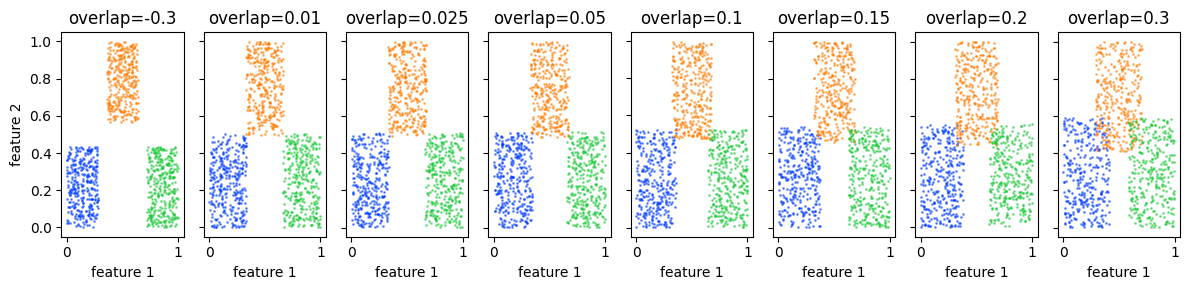

The analyzing target is overlap=0.15.
Repeat 1/2 Fold 1/5
GC accuracy: 0.990, SFC accuracy: 0.995
Repeat 1/2 Fold 2/5
GC accuracy: 0.985, SFC accuracy: 0.980
Repeat 1/2 Fold 3/5
GC accuracy: 0.995, SFC accuracy: 0.995
Repeat 1/2 Fold 4/5
GC accuracy: 0.980, SFC accuracy: 0.975
Repeat 1/2 Fold 5/5
GC accuracy: 0.985, SFC accuracy: 0.970
Repeat 2/2 Fold 1/5
GC accuracy: 0.990, SFC accuracy: 0.985
Repeat 2/2 Fold 2/5
GC accuracy: 0.985, SFC accuracy: 0.995
Repeat 2/2 Fold 3/5
GC accuracy: 0.975, SFC accuracy: 0.980
Repeat 2/2 Fold 4/5
GC accuracy: 0.990, SFC accuracy: 0.995
Repeat 2/2 Fold 5/5
GC accuracy: 0.975, SFC accuracy: 0.975


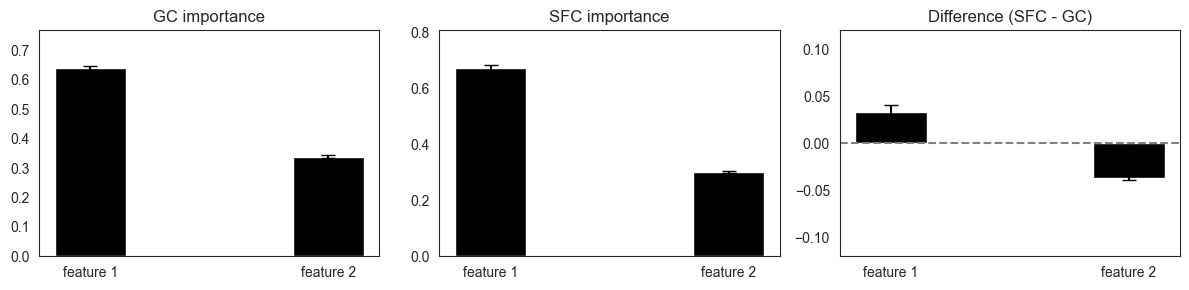

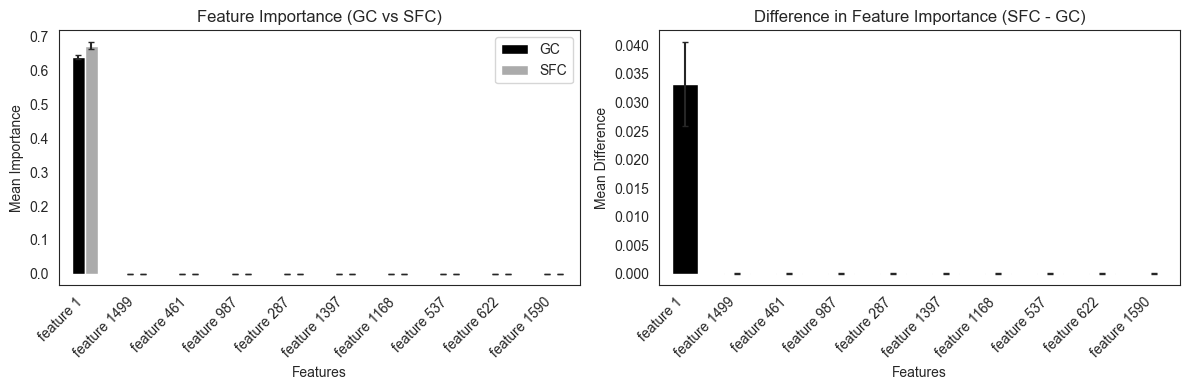

Top ranked genes across folds (based on rank sum):

              fold_0  fold_1  fold_2  fold_3  fold_4  fold_5  fold_6  fold_7  \
feature 1        1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   
feature 1499    88.0    62.0    68.0     4.0    51.0    20.0   523.0   123.0   
feature 461    110.0    48.0   127.0    54.0    51.0   546.0   100.0    62.0   
feature 987    258.0   166.0   304.0   110.0    51.0    66.0    52.0   224.0   
feature 287    129.0    28.0   274.0    64.0    51.0   623.0   130.0    23.0   
feature 1397    99.0   116.0    36.0   600.0     6.0   270.0   345.0     3.0   
feature 1168    82.0     8.0    54.0   600.0    51.0   108.0   617.0    79.0   
feature 537    574.0   480.0   346.0    31.0    51.0    18.0    68.0   172.0   
feature 622    122.0    25.0    96.0   286.0    51.0   623.0    61.0    91.0   
feature 1590    58.0   148.0    72.0   379.0    51.0   116.0   361.0   578.0   

              fold_8  fold_9  rank_sum  
feature 1        1.0     1

In [10]:
if __name__ == "__main__":
    main()

In [11]:
def main2():
    # Parameters for data deneration
    n_rows = 1000
    n_genes = 1998
    n_class = 3
    data_overlap = [-0.3, 0.01, 0.025, 0.05, 0.10, 0.15, 0.2, 0.3]

    # Generate data (for demonstartion)
    generated_data, pt_class, data_overlap = generate_data(n_rows, n_genes, n_class, data_overlap)

    # Visualize generated data for gene 1 and gene 2 (for demonstration)
    plot_generated_data(generated_data, pt_class, data_overlap)

    # Choose overlap index for model training (example: 5 =>  data_overlap[5] was used as test case))(for demonstration)
    overlap_idx = 0
    print(f"The analyzing target is overlap={data_overlap[overlap_idx]}.")
    
    # Specify the data to be analyzed with its class
    X = generated_data[:, :, overlap_idx]   # insert data here at actual analyses, float (sample_number(row) x feature_number(col) )
    y = pt_class                            # insert data here at actual analyses, int (class nunmber)

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Define LightGBM parameters: may be required to be optimized for each data to incease the calssification accuracy by Optuna or Grid search.
    params = {
        "objective": "multiclass",
        "num_class": n_class,
        "metric": "multi_logloss",
        "learning_rate": 0.1,
        "num_leaves": 16,
        "min_data_in_leaf": 100,
        "max_depth": 5,
        "verbosity": -1,
        "seed": 2022,
    }

    # Construct grand_truth matrix (example, must be consistent with problem)
    overlap_w = 0.05         # hyperparameter determing overlap assumed in SFC
    grand_truth_SFC = np.array([[1.-overlap_w,overlap_w,0],               # label for class 0
                                [overlap_w,1.-2*overlap_w,overlap_w],     # label for class 1
                                [0,overlap_w,1.-overlap_w]                # label for class 2
                               ])

    # Run cross-validation
    results = run_cv_lgbm(X_scaled, y, grand_truth_SFC, params, n_splits=5, repeated=2, acc_threshold=2 / 3)

    # Plot feature importance comparison for first 2 features
    feature_names = [f"feature {i+1}" for i in range(n_genes)]
    plot_feature_importance_comparison(results, feature_names)

    # Plot feature importance comparison for top N features
    feature_names = [f"feaure {i+1}" for i in range(n_genes)]
    plot_feature_importance_comparison_topN(
        importance_gc_mean=results["importance_GC_mean"],
        importance_gc_std=results["importance_GC_std"],
        importance_sfc_mean=results["importance_SFC_mean"],
        importance_sfc_std=results["importance_SFC_std"],
        importance_diff_mean=results["importance_Diff_mean"],
        importance_diff_std=results["importance_Diff_std"],
        gene_rank_matrix=results["gene_rank_matrix"],
        top_n=10
    )

    # Show top 10 ranked genes
    show_top_ranked_genes(results["gene_rank_matrix"], top_n=10)

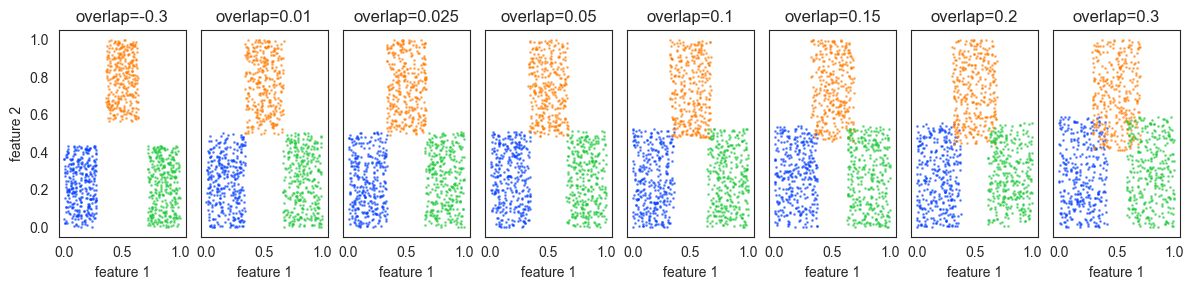

The analyzing target is overlap=-0.3.
Repeat 1/2 Fold 1/5
GC accuracy: 1.000, SFC accuracy: 1.000
Repeat 1/2 Fold 2/5
GC accuracy: 1.000, SFC accuracy: 1.000
Repeat 1/2 Fold 3/5
GC accuracy: 1.000, SFC accuracy: 1.000
Repeat 1/2 Fold 4/5
GC accuracy: 1.000, SFC accuracy: 1.000
Repeat 1/2 Fold 5/5
GC accuracy: 1.000, SFC accuracy: 1.000
Repeat 2/2 Fold 1/5
GC accuracy: 1.000, SFC accuracy: 1.000
Repeat 2/2 Fold 2/5
GC accuracy: 1.000, SFC accuracy: 1.000
Repeat 2/2 Fold 3/5
GC accuracy: 1.000, SFC accuracy: 1.000
Repeat 2/2 Fold 4/5
GC accuracy: 1.000, SFC accuracy: 1.000
Repeat 2/2 Fold 5/5
GC accuracy: 1.000, SFC accuracy: 1.000


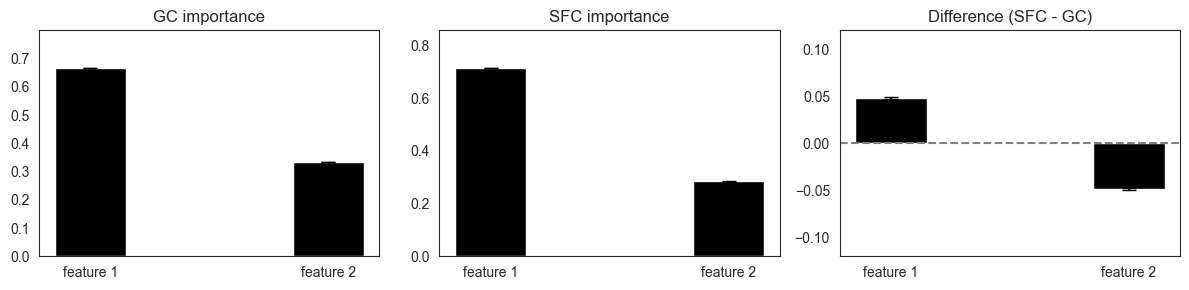

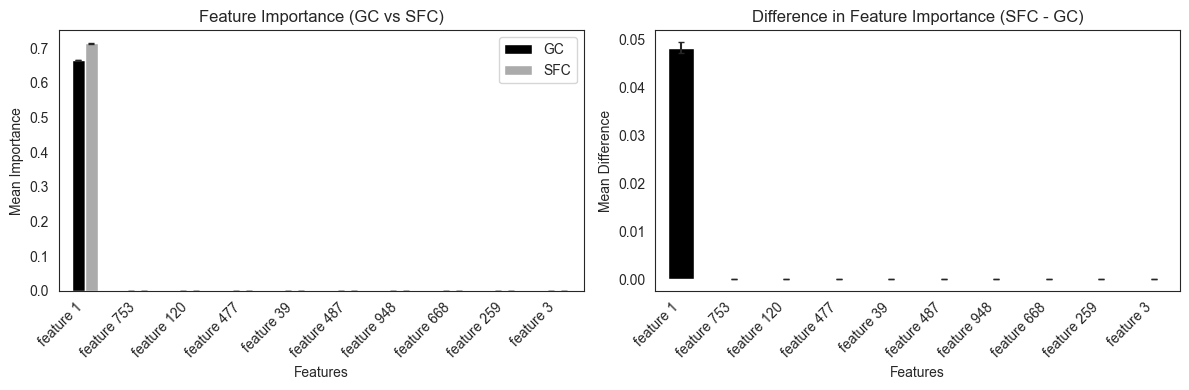

Top ranked genes across folds (based on rank sum):

             fold_0  fold_1  fold_2  fold_3  fold_4  fold_5  fold_6  fold_7  \
feature 1       1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   
feature 753    10.0    69.0    73.0   161.0   130.0   172.0   497.0   154.0   
feature 120   149.0    38.0    78.0   153.0   581.0   168.0   497.0   110.0   
feature 477   491.0    12.0    59.0   192.0   175.0   203.0     9.0    62.0   
feature 39     42.0    94.0   125.0   120.0   581.0   540.0    60.0    21.0   
feature 487   188.0    79.0   167.0     3.0   581.0     2.0   497.0   584.0   
feature 948    27.0   268.0   161.0   136.0   581.0   184.0     6.0   269.0   
feature 668   173.0   499.0   572.0   244.0    24.0   351.0    90.0   173.0   
feature 259   154.0   200.0   139.0    98.0   581.0    28.0   152.0   265.0   
feature 3      79.0   249.0   122.0    32.0   561.0    22.0   151.0   584.0   

             fold_8  fold_9  rank_sum  
feature 1       1.0     1.0      10.0 

In [12]:
if __name__ == "__main__":
    main2()